In [1]:
import glob
import os
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import torch
import albumentations as A
import json
import time

from dataloaders import TacoLoaders
from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from utils import *
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from utils import visualize

In [2]:
def resize_input():
    transform = [
        A.Resize(height=512, width=512, p=1),
    ]
    return A.Compose(transform)

In [3]:
def get_training_augmentation():
    transform = [

        A.HorizontalFlip(p=0.5),
        
        
        A.RandomCrop(height=512, width=512, p=1),
        A.ShiftScaleRotate(scale_limit=0.1, 
                            rotate_limit=10, 
                            shift_limit=0.2, 
                            p=1, 
                            border_mode=0),
        A.GaussNoise (p=0.1),
        A.Perspective(p=0.5),

        
    ]
    return A.Compose(transform)

In [4]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [5]:
class My_network():
    
    
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=2, 
            activation=ACTIVATION,
        )
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
        
        
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):
            
            start_time = time.time() ## точка отсчета времени
            
            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)
            

            if i%5==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 4))
                print(round(valid_logs['iou_score'] , 4))

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)
                
            print("Time per epoch", round(time.time() - start_time, 2), "seconds", end='\r')
    
    def eval(self, dataloader, model_path='./best_model.pth'):
        best_model = torch.load(model_path)
        test_epoch = smp.utils.train.ValidEpoch(
                         model=best_model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

        logs = test_epoch.run(dataloader)
        return best_model

In [6]:
network = My_network(loss, metrics)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
1200 150 150
Example image and mask:


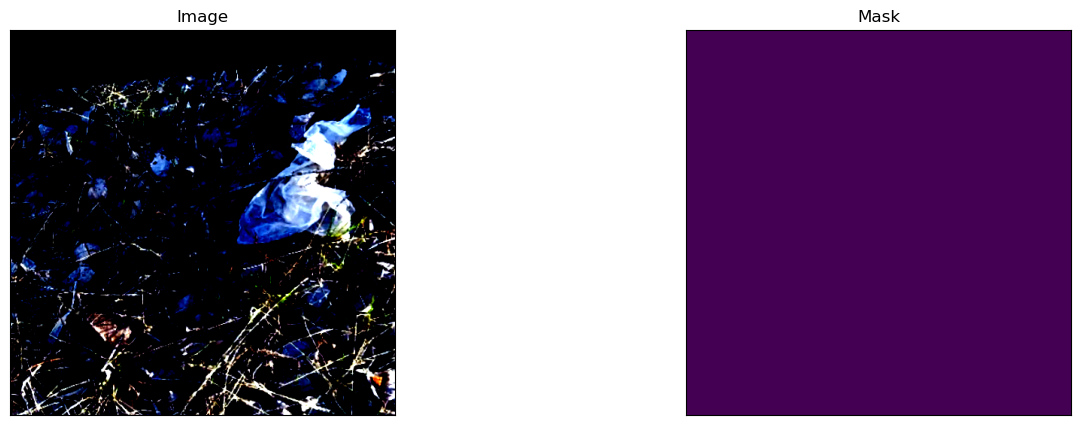

In [7]:
taco_loaders = TacoLoaders(batch_size=16,
                           augmentation=get_training_augmentation(),
                           resize_input=resize_input(),
                           preprocessing_fn=preprocessing_fn,)
print("Example image and mask:")
taco_loaders.show_example()

In [ ]:
print("Training model:")
network.run_training(taco_loaders, n_epochs=100)

Training model:
==Epoch 0==
Train/Val IoU:
0.02
0.0354
==Epoch 5==och 16.26 seconds
Train/Val IoU:
0.0211
0.0354
==Epoch 10==ch 15.33 seconds
Train/Val IoU:
0.0208
0.0354
==Epoch 15==ch 15.27 seconds
Train/Val IoU:
0.0208
0.0354
==Epoch 20==ch 16.56 seconds
Train/Val IoU:
0.0204
0.0354
==Epoch 25==ch 16.11 seconds
Train/Val IoU:
0.0198
0.0354
==Epoch 30==ch 15.64 seconds
Train/Val IoU:
0.0212
0.0354
==Epoch 35==ch 15.49 seconds
Train/Val IoU:
0.0199
0.0354
==Epoch 40==ch 16.79 seconds
Train/Val IoU:
0.0211
0.0354
==Epoch 45==ch 15.39 seconds
Train/Val IoU:
0.0197
0.0354
==Epoch 50==ch 16.48 seconds
Train/Val IoU:
0.0201
0.0354
==Epoch 55==ch 15.88 seconds
Train/Val IoU:
0.0198
0.0354
==Epoch 60==ch 17.34 seconds
Train/Val IoU:
0.0209
0.0354
==Epoch 65==ch 16.6 secondss
Train/Val IoU:
0.02
0.0354
==Epoch 70==ch 15.7 secondss
Train/Val IoU:
0.0197
0.0354
==Epoch 75==ch 15.29 seconds
Train/Val IoU:
0.0208
0.0354
==Epoch 80==ch 15.57 seconds
Train/Val IoU:
0.0198
0.0354
==Epoch 85==ch 16.1

In [ ]:
print("Eval model:")
best_model = network.eval(taco_loaders.test_loader)
compare_predictions(taco_loaders, best_model)